<a href="https://colab.research.google.com/github/kumar-abhishek/imbalanced-machine-learning-book/blob/main/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running a default CNN model on MNIST dataset to benchmark it's accuracy


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time
import torchvision
import random
import copy
import cv2
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

In [ ]:
def train(train_dataloader,val_dataloader, model = None, epochs=1):
    torch.manual_seed(0)
    #device = torch.device("cpu")
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1)
    train_losses = []
    val_losses = []
    val_accuracies = []
    model.train()
    best_val_acc = 0.
    patience = 0
    optimal_model = copy.deepcopy(model)
    for epoch in range(epochs):
        train_epoch_loss = 0.
        n_total = 0
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #if b_i % 10 == 0:
            #print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
            #    epoch, b_i, len(train_dataloader),
            #    100. * b_i / len(train_dataloader), loss.item()))
            train_epoch_loss+= loss.cpu().item()*len(y)
            n_total+= len(y)
        train_epoch_loss= train_epoch_loss/n_total
        train_losses.append(train_epoch_loss)
        print("Epoch %d/%d train loss: %.4f"%(epoch+1, epochs,train_epoch_loss))
        targets = []
        outputs = []
        success = 0
        n_total = 0
        with torch.no_grad():
            loss =0.
            val_epoch_loss = 0.
            for X, y in val_dataloader:
                X, y = X.to(device), y.to(device)
                pred_prob = model(X)
                loss += F.nll_loss(pred_prob, y, reduction='sum').detach().cpu().numpy().item()  # loss summed across the batch
                pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
                success += pred.eq(y.view_as(pred)).sum().detach().cpu().numpy()
                outputs.append(pred.view(-1))
                targets.append(y)
                n_total+=len(y)
            accuracy = 100. * success / n_total
            if accuracy>best_val_acc:
                best_val_acc = accuracy
                optimal_model = copy.deepcopy(model)
                patience = 0
            else:
                patience+=1
            val_loss = loss/n_total
            val_accuracies.append(accuracy)
            val_losses.append(val_loss)
        print("Epoch %d/%d validation loss: %.4f"%(epoch+1, epochs, val_loss))
        print("Epoch %d/%d validation accuracy: %.4f"%(epoch+1, epochs, accuracy))
        if patience>2:
            print("Early stopping at epoch %d/%d"%(epoch+1, epochs))
            break
    last_epoch = epoch
    return optimal_model, train_losses, val_losses, val_accuracies, last_epoch

def test(model):
    model.eval()
    loss = 0
    success = 0
    targets = []
    outputs = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').detach().cpu().numpy() # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()
            outputs.append(pred.view(-1))
            targets.append(y)

    loss /= len(test_dataloader.dataset)

    accuracy = 100. * success / len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset), accuracy))
    outputs = torch.cat(outputs,0).detach().cpu().numpy()
    targets = torch.cat(targets,0).detach().cpu().numpy()
    cf = confusion_matrix(outputs, targets, labels=np.array(range(10)))

    return accuracy, cf

from sklearn.metrics import confusion_matrix
import seaborn as sns
def get_class_percentages(cm):
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    percentages = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                percentages[i, j] = ''
            else:
                percentages[i, j] = '%.1f%%' % p
    return percentages

## Orignal Mnist Dataset Class distribution

100%|██████████| 9912422/9912422 [00:00<00:00, 332637623.17it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 91908720.66it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 178437777.92it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15338589.99it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Distribution of classes in original train dataset:


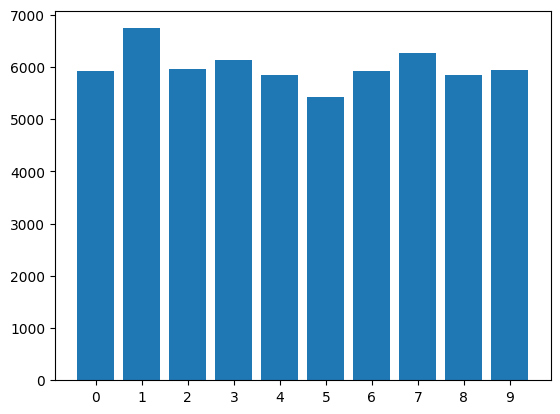

In [ ]:
trainset = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))]))
m=len(trainset)

train_data, val_data = random_split(trainset, [int(m-m*0.2), m - int(m-m*0.2)])

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

print(Counter(trainset.targets.numpy()))

print('Distribution of classes in original train dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(trainset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

In [ ]:
test_ds = datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))]))

test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=500, shuffle=True)

# Balanced/Orignal Dataset Training

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
epochs = 10
optimal_model, train_losses, val_losses, val_accuracies, last_epoch = train(train_dataloader, val_dataloader, ConvNet().to(device), epochs=epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/10 train loss: 0.5060
Epoch 1/10 validation loss: 0.2774
Epoch 1/10 validation accuracy: 91.9500
Epoch 2/10 train loss: 0.2258
Epoch 2/10 validation loss: 0.1880
Epoch 2/10 validation accuracy: 94.5917
Epoch 3/10 train loss: 0.1532
Epoch 3/10 validation loss: 0.1407
Epoch 3/10 validation accuracy: 95.8833
Epoch 4/10 train loss: 0.1150
Epoch 4/10 validation loss: 0.1164
Epoch 4/10 validation accuracy: 96.6667
Epoch 5/10 train loss: 0.0959
Epoch 5/10 validation loss: 0.1011
Epoch 5/10 validation accuracy: 97.0917
Epoch 6/10 train loss: 0.0820
Epoch 6/10 validation loss: 0.0918
Epoch 6/10 validation accuracy: 97.3667
Epoch 7/10 train loss: 0.0736
Epoch 7/10 validation loss: 0.0824
Epoch 7/10 validation accuracy: 97.4750
Epoch 8/10 train loss: 0.0664
Epoch 8/10 validation loss: 0.0842
Epoch 8/10 validation accuracy: 97.5500
Epoch 9/10 train loss: 0.0619
Epoch 9/10 validation loss: 0.0755
Epoch 9/10 validation accuracy: 97.7083
Epoch 10/10 train loss: 0.0565
Epoch 10/10 validation l

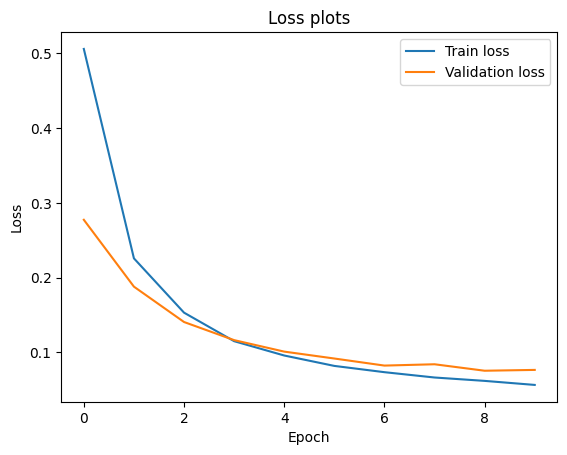

In [ ]:
plt.plot(np.array(range(last_epoch+1)), train_losses, label = "Train loss")
plt.plot(np.array(range(last_epoch+1)), val_losses, label = "Validation loss")
plt.title('Loss plots')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

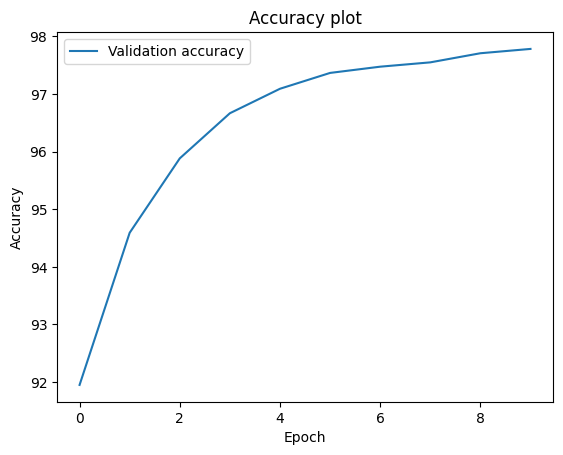

In [ ]:
plt.plot(np.array(range(last_epoch+1)), val_accuracies, label = "Validation accuracy")
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test Model

In [ ]:
print("On vanilla MNIST dataset")
test_acc, cf = test(optimal_model)
print("test accuracy : ", str(test_acc))
percentages0 = get_class_percentages(cf)

On vanilla MNIST dataset

Test dataset: Overall Loss: 0.0412, Overall Accuracy: 9859/10000 (99%)

test accuracy :  98.59


# Performance of the Model on Imbalanced MNIST Dataset

### Create Imbalanced Dataset

In [ ]:
# generate imbalanced dataset
torch.manual_seed(0)
num_classes = 10
sample_probs = torch.rand(num_classes)

idx_to_remove = [idx for idx, target in enumerate(trainset.targets)
              if random.random() > sample_probs[target] #or target in range(3, 10)
              ]
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.
                                            targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data,
                                            idx_to_remove, axis=0)

m = len(imbalanced_train_dataset)

imbalanced_train_data, imbalanced_val_data = random_split(imbalanced_train_dataset, [int(m-m*0.2), m - int(m-m*0.2)])

imbalanced_train_dataloader = torch.utils.data.DataLoader(imbalanced_train_data, batch_size=128, shuffle=True)
imbalanced_val_dataloader = torch.utils.data.DataLoader(imbalanced_val_data, batch_size=128, shuffle=True)



Distribution of classes in Imbalanced dataset:
Counter({7: 5609, 1: 5202, 9: 3767, 5: 3422, 6: 2963, 0: 2907, 8: 2654, 4: 1771, 3: 865, 2: 521})


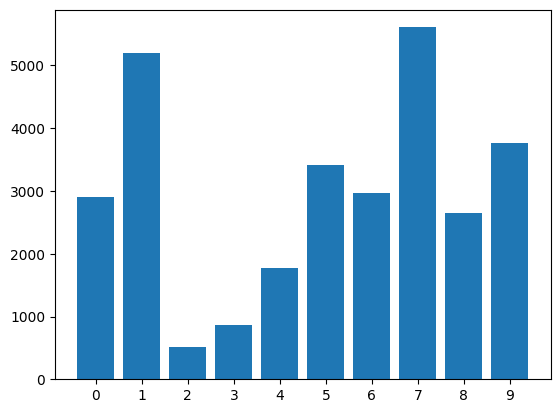

In [ ]:
print('Distribution of classes in Imbalanced dataset:')
print(Counter(imbalanced_train_data.dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_data.dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

### train model on imbalanced dataset

In [ ]:
epochs = 10
imb_optimal_model, imb_train_losses, imb_val_losses, imb_val_accuracies, imb_last_epoch = train(imbalanced_train_dataloader, imbalanced_val_dataloader, ConvNet().to(device), epochs=epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/10 train loss: 0.6330
Epoch 1/10 validation loss: 0.3397
Epoch 1/10 validation accuracy: 89.7255
Epoch 2/10 train loss: 0.2657
Epoch 2/10 validation loss: 0.2350
Epoch 2/10 validation accuracy: 92.6731
Epoch 3/10 train loss: 0.2040
Epoch 3/10 validation loss: 0.2123
Epoch 3/10 validation accuracy: 93.4647
Epoch 4/10 train loss: 0.1610
Epoch 4/10 validation loss: 0.1789
Epoch 4/10 validation accuracy: 94.7785
Epoch 5/10 train loss: 0.1338
Epoch 5/10 validation loss: 0.1604
Epoch 5/10 validation accuracy: 95.1828
Epoch 6/10 train loss: 0.1141
Epoch 6/10 validation loss: 0.1374
Epoch 6/10 validation accuracy: 95.6881
Epoch 7/10 train loss: 0.0972
Epoch 7/10 validation loss: 0.1168
Epoch 7/10 validation accuracy: 96.4797
Epoch 8/10 train loss: 0.0852
Epoch 8/10 validation loss: 0.1159
Epoch 8/10 validation accuracy: 96.4123
Epoch 9/10 train loss: 0.0750
Epoch 9/10 validation loss: 0.1045
Epoch 9/10 validation accuracy: 97.0355
Epoch 10/10 train loss: 0.0716
Epoch 10/10 validation l

### test on test set

In [ ]:
print("performance on MNIST testset")
imb_optimal_model_test_acc, cf = test(imb_optimal_model)
print("test accuracy : ", str(imb_optimal_model_test_acc))
percentages1 = get_class_percentages(cf)

performance on MNIST testset


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)



Test dataset: Overall Loss: 0.1003, Overall Accuracy: 9701/10000 (97%)

test accuracy :  97.01


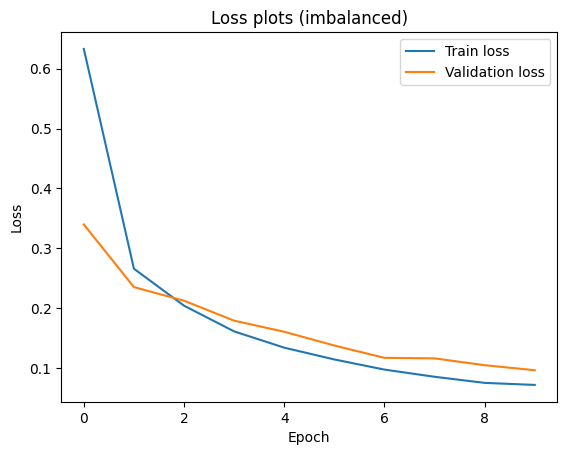

In [ ]:
plt.plot(np.array(range(imb_last_epoch+1)), imb_train_losses, label = "Train loss")
plt.plot(np.array(range(imb_last_epoch+1)), imb_val_losses, label = "Validation loss")
plt.title('Loss plots (imbalanced)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

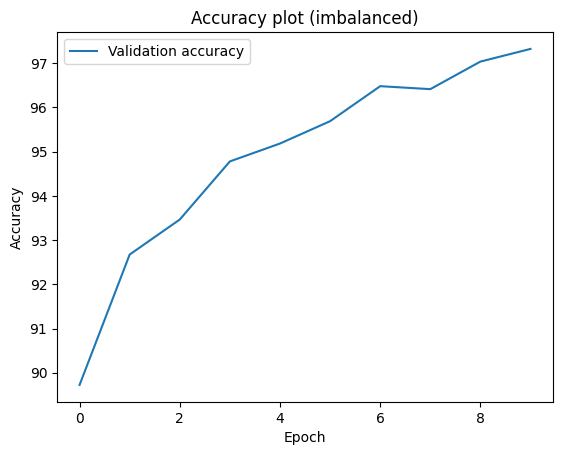

In [ ]:
plt.plot(np.array(range(imb_last_epoch+1)), imb_val_accuracies, label = "Validation accuracy")
plt.title('Accuracy plot (imbalanced)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Balance the above create imbalanced dataset using VAE
Example references:
1. https://github.com/alexmanuele/Creating-Synthetic-Data-with-VAE/blob/master/using_VAE_to_improve_classification_performance.ipynb

2. https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

3. you can use your own references too

# Loading Mnist data

# Model definition

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc #.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale #.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu.to(device) + sigma*self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims).to(device)
        self.decoder = Decoder(latent_dims).to(device)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

# Training and Testing functions

In [ ]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_ds.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][np.random.randint(500, size=1)[0]] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_ds[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n-1:
            ax.set_title('Reconstructed images')
            plt.show()

In [ ]:
def train_VAE(train_dataloader,val_dataloader, model = None, epochs=1):
    torch.manual_seed(0)
    #device = torch.device("cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    train_losses = []
    val_losses = []
    val_accuracies = []
    model.train()
    best_val_loss = 9999999999999.
    patience = 0
    optimal_model = copy.deepcopy(model)
    for epoch in range(epochs):
        train_epoch_loss = 0.
        n_total = 0
        for b_i, (X, _) in enumerate(train_dataloader):
            X = X.to(device)
            model = model.to(device)
            x_hat = model(X)
            loss = ((X - x_hat)**2).sum() + model.encoder.kl
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #if b_i % 10 == 0:
            #print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
            #    epoch, b_i, len(train_dataloader),
            #    100. * b_i / len(train_dataloader), loss.item()))
            train_epoch_loss+= loss.cpu().item()
            n_total+= len(X)
        train_epoch_loss= train_epoch_loss/n_total
        train_losses.append(train_epoch_loss)
        print("Epoch %d/%d VAE train loss: %.4f"%(epoch+1, epochs,train_epoch_loss))

        n_total = 0
        model.eval()
        with torch.no_grad():
            val_epoch_loss = 0.
            for x, _ in val_dataloader:
                x = x.to(device)
                x_hat= model(x)
                loss = ((x - x_hat)**2).sum() + model.encoder.kl
                val_epoch_loss+=loss.detach().cpu().numpy()
                n_total+=len(X)
            val_epoch_loss = val_epoch_loss/n_total
            if val_epoch_loss<best_val_loss:
                best_val_loss = val_epoch_loss
                optimal_model = copy.deepcopy(model)
                patience = 0
            else:
                patience+=1
            val_losses.append(val_epoch_loss)
        print("Epoch %d/%d VAE validation loss: %.4f"%(epoch+1, epochs, val_epoch_loss))
        if patience>2:
            print("Early stopping at epoch %d/%d"%(epoch+1, epochs))
            break
        plot_ae_outputs(model.encoder,model.decoder,n=10)
    last_epoch = epoch
    return optimal_model, train_losses, val_losses, last_epoch


# Visualization Module

# Start Visual Auto Encoder Training

Epoch 1/50 VAE train loss: 765.9508
Epoch 1/50 VAE validation loss: 1186.6334


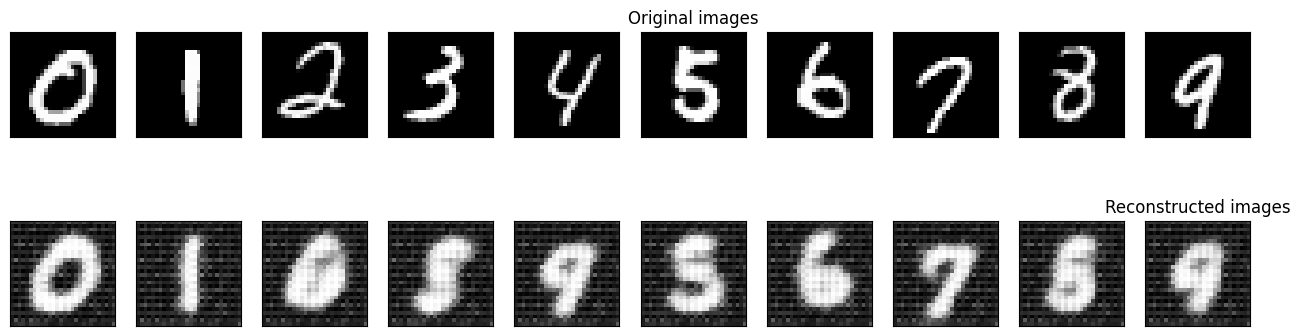

Epoch 2/50 VAE train loss: 478.2544
Epoch 2/50 VAE validation loss: 931.2328


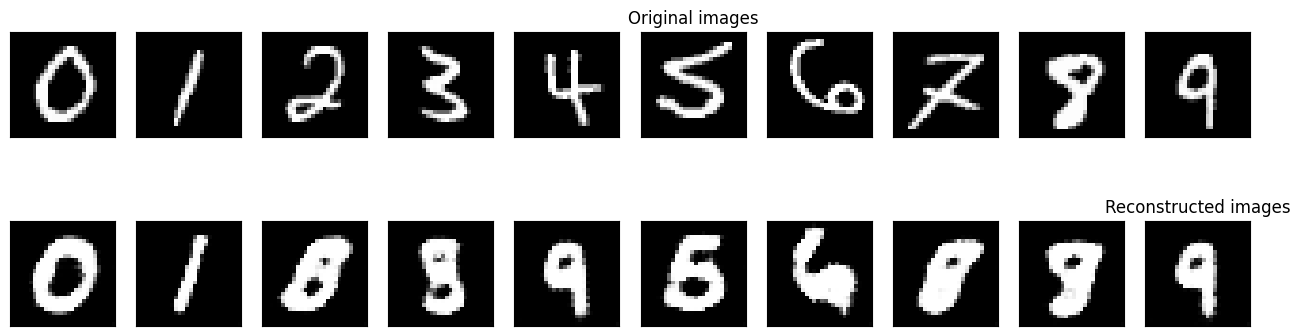

Epoch 3/50 VAE train loss: 462.7002
Epoch 3/50 VAE validation loss: 918.2886


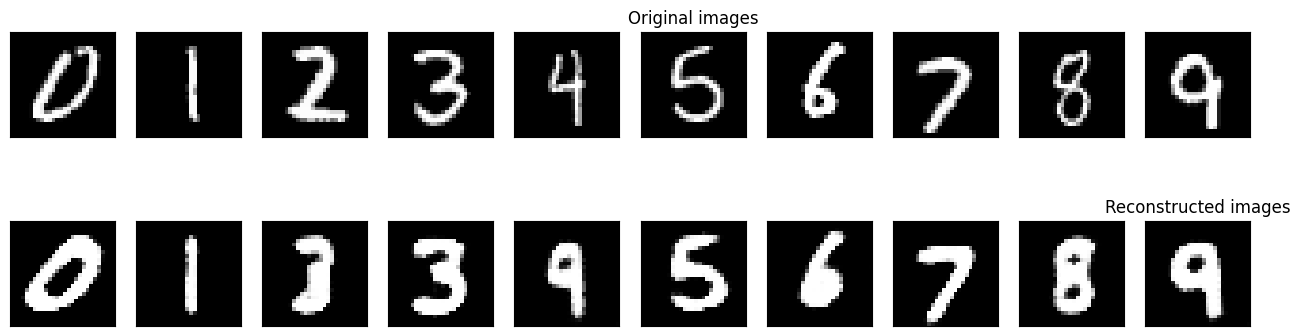

Epoch 4/50 VAE train loss: 458.7706
Epoch 4/50 VAE validation loss: 914.0536


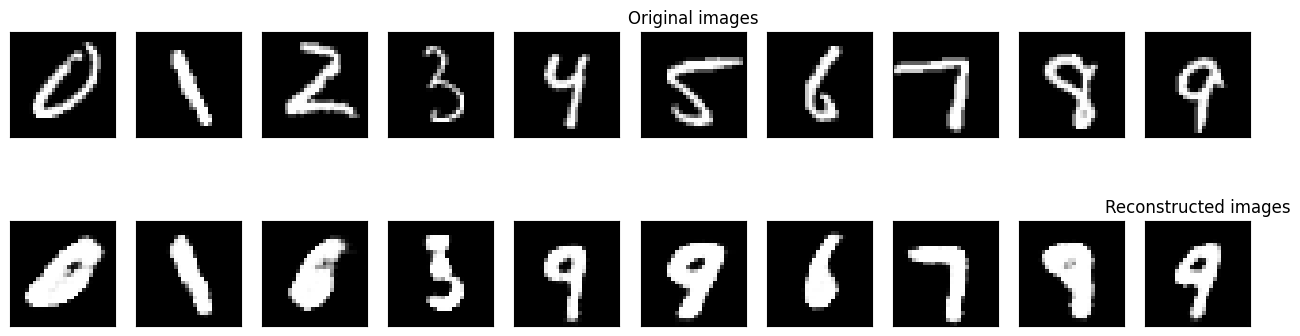

Epoch 5/50 VAE train loss: 455.9634
Epoch 5/50 VAE validation loss: 909.0649


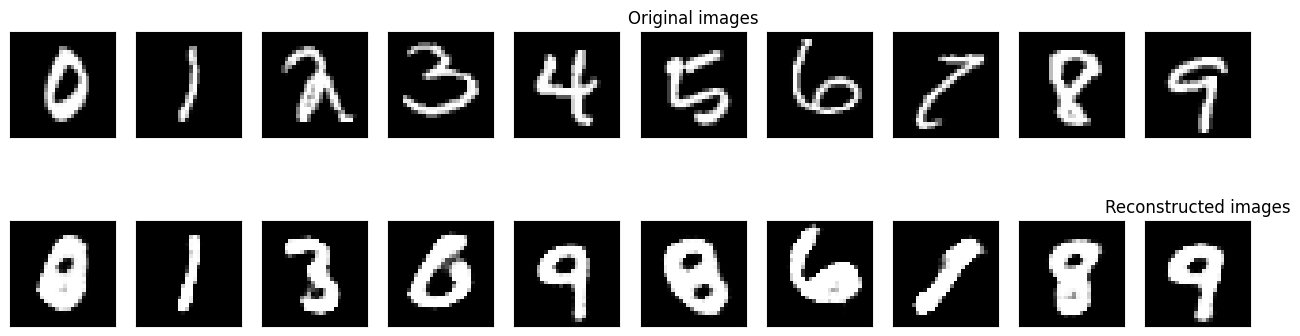

Epoch 6/50 VAE train loss: 454.2342
Epoch 6/50 VAE validation loss: 907.3674


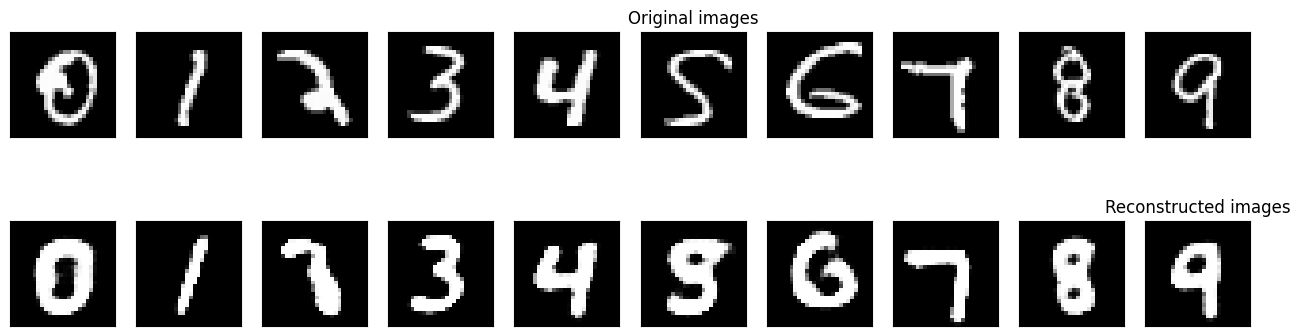

Epoch 7/50 VAE train loss: 452.5140
Epoch 7/50 VAE validation loss: 903.5501


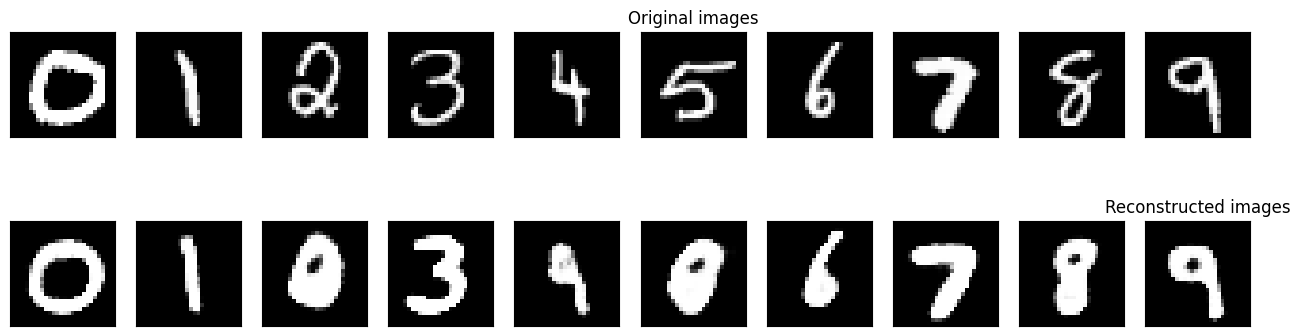

Epoch 8/50 VAE train loss: 451.3821
Epoch 8/50 VAE validation loss: 901.1938


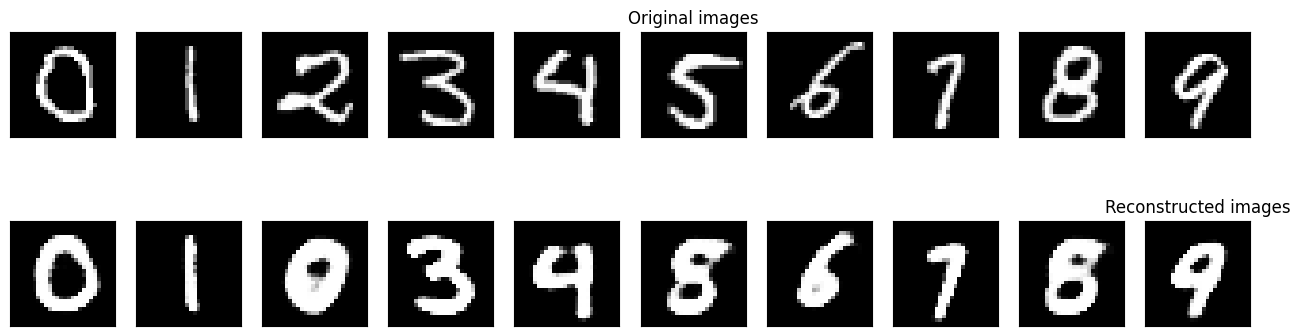

Epoch 9/50 VAE train loss: 450.5377
Epoch 9/50 VAE validation loss: 905.5299


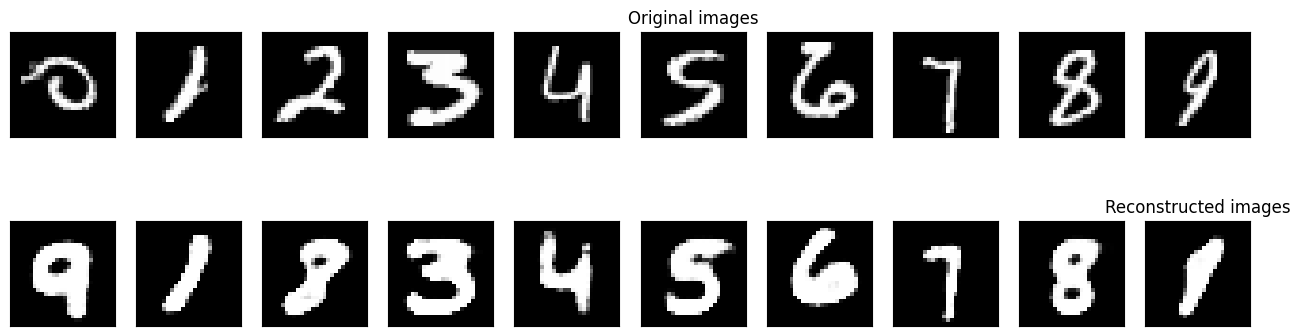

Epoch 10/50 VAE train loss: 449.6816
Epoch 10/50 VAE validation loss: 897.5496


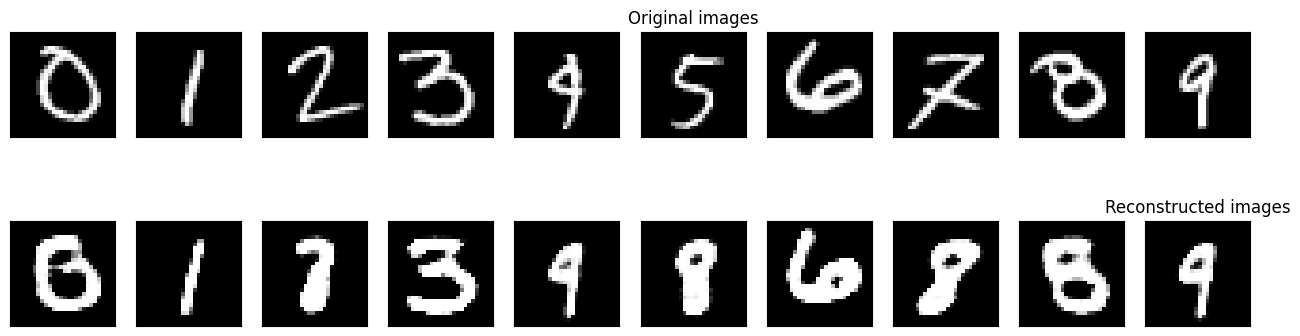

Epoch 11/50 VAE train loss: 448.7792
Epoch 11/50 VAE validation loss: 899.4510


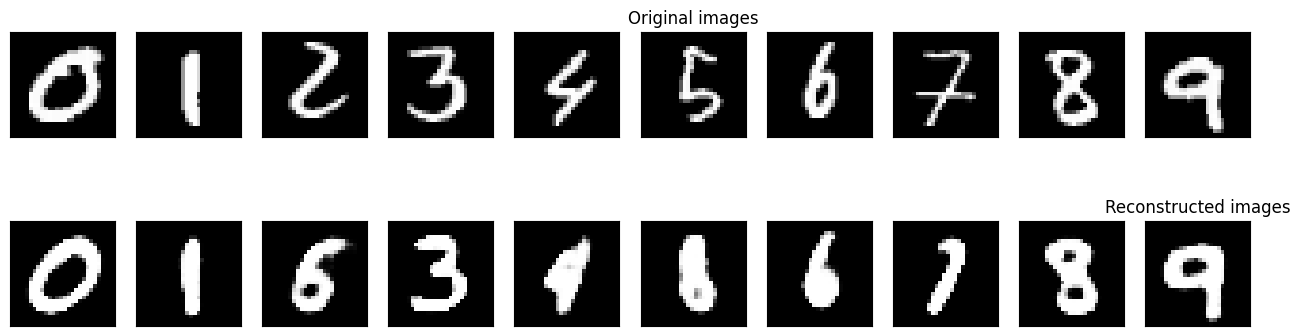

Epoch 12/50 VAE train loss: 447.7921
Epoch 12/50 VAE validation loss: 896.7499


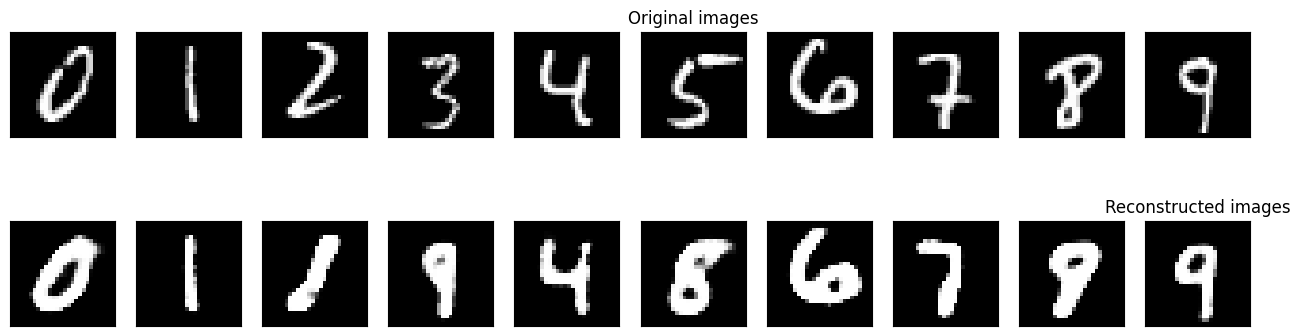

Epoch 13/50 VAE train loss: 447.0288
Epoch 13/50 VAE validation loss: 893.2339


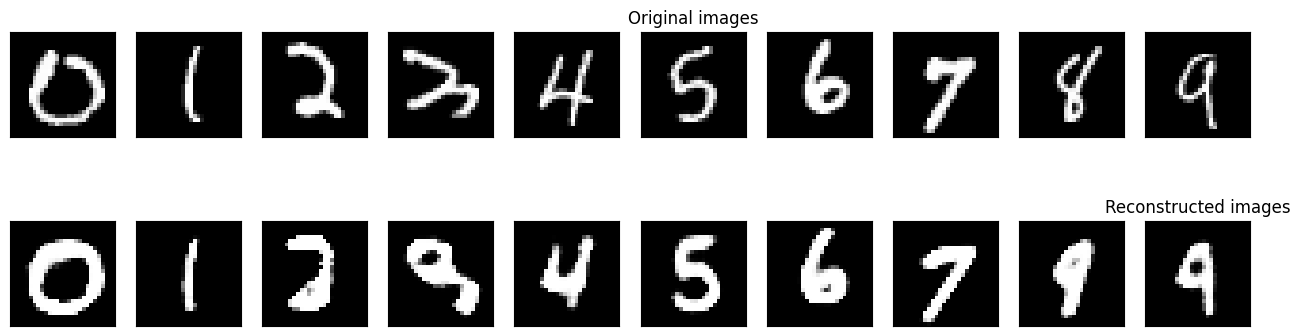

Epoch 14/50 VAE train loss: 446.2901
Epoch 14/50 VAE validation loss: 893.4734


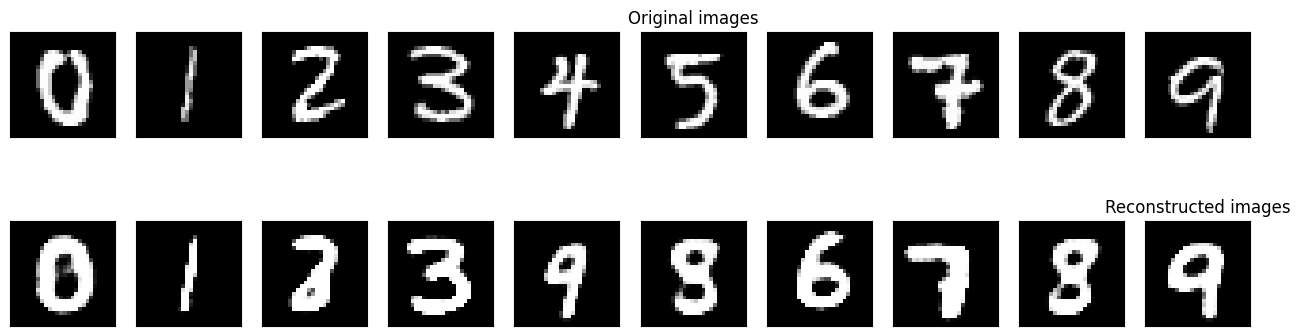

Epoch 15/50 VAE train loss: 445.8156
Epoch 15/50 VAE validation loss: 892.8562


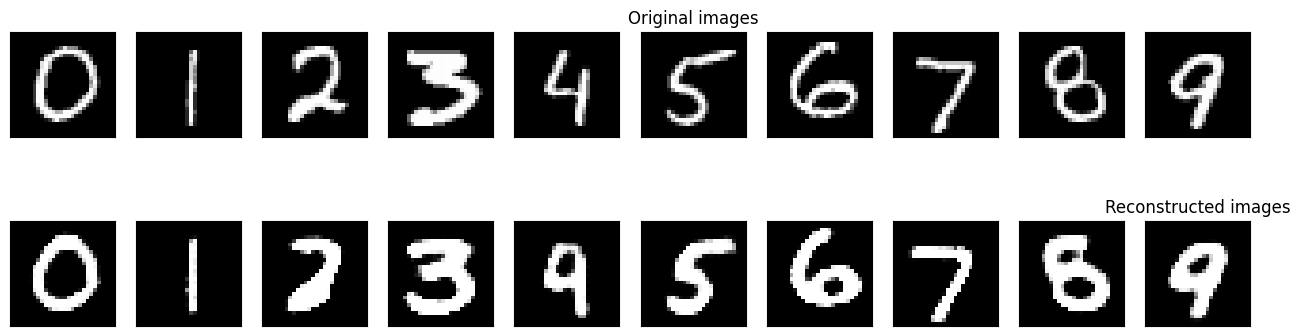

Epoch 16/50 VAE train loss: 445.0569
Epoch 16/50 VAE validation loss: 891.3187


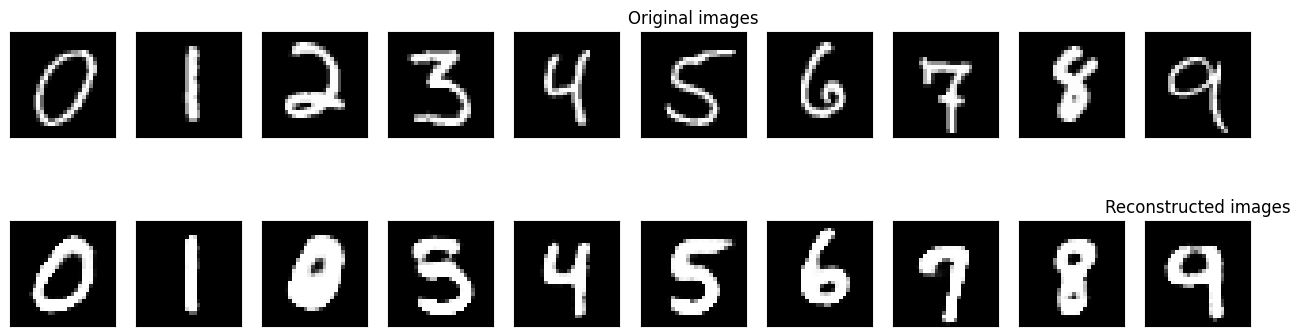

Epoch 17/50 VAE train loss: 444.8637
Epoch 17/50 VAE validation loss: 890.8694


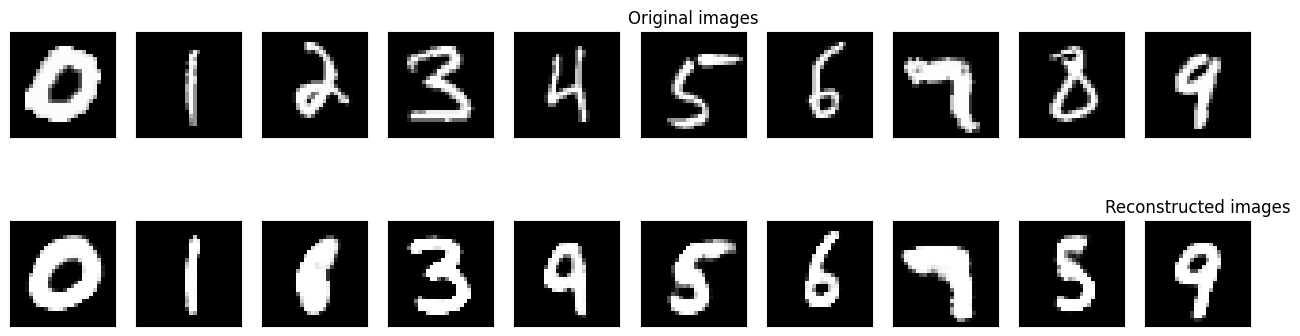

Epoch 18/50 VAE train loss: 443.9679
Epoch 18/50 VAE validation loss: 890.2924


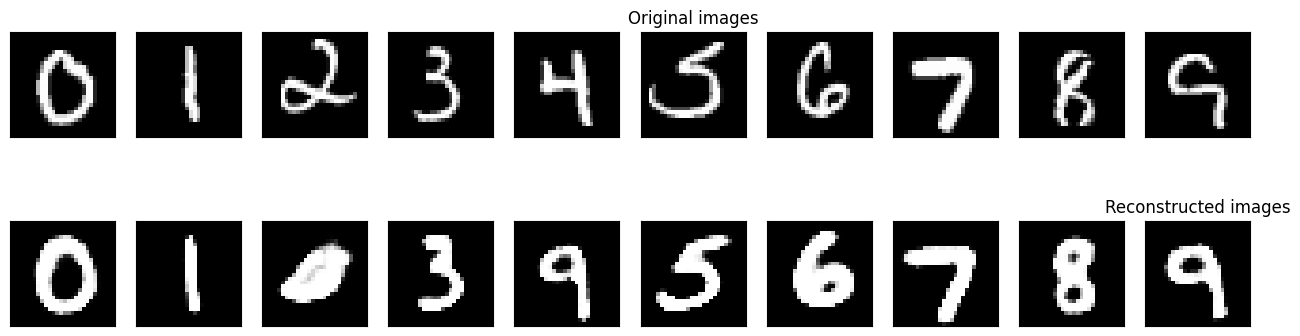

Epoch 19/50 VAE train loss: 443.7183
Epoch 19/50 VAE validation loss: 891.0885


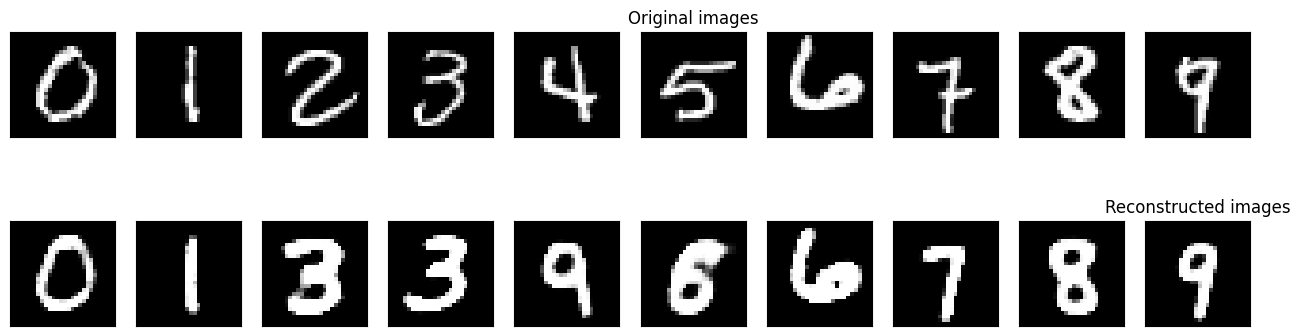

Epoch 20/50 VAE train loss: 443.3929
Epoch 20/50 VAE validation loss: 888.5157


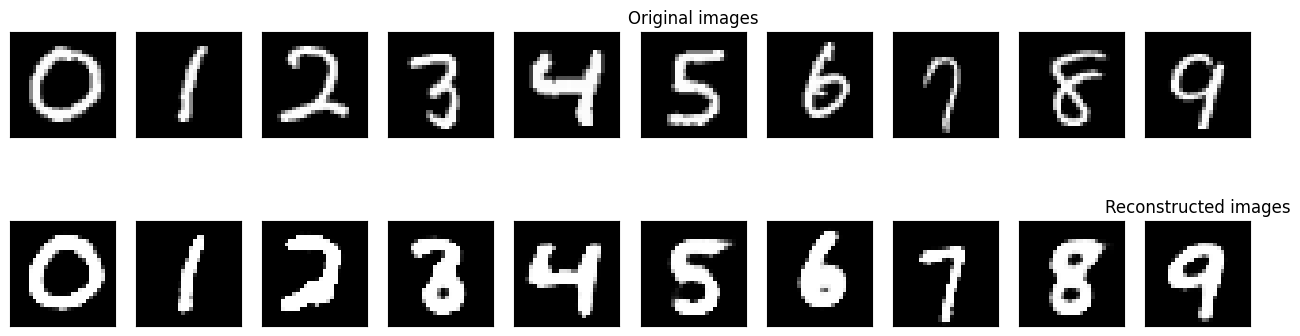

Epoch 21/50 VAE train loss: 442.7649
Epoch 21/50 VAE validation loss: 889.6259


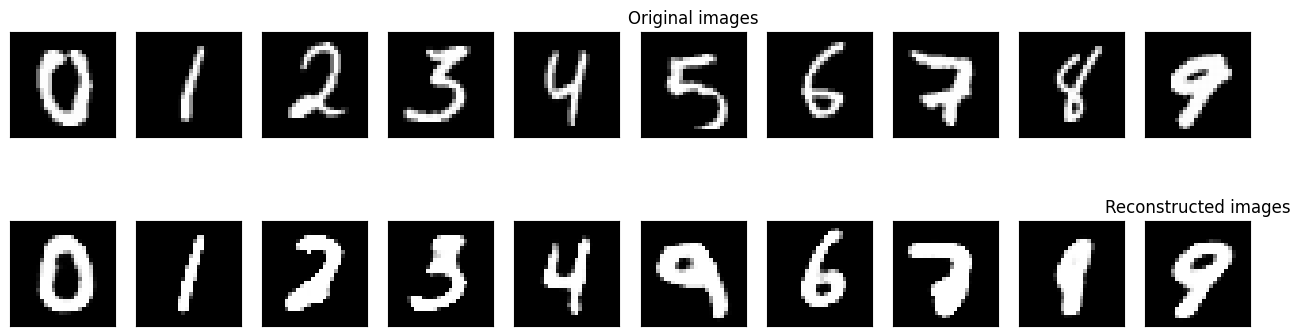

Epoch 22/50 VAE train loss: 442.5023
Epoch 22/50 VAE validation loss: 887.3322


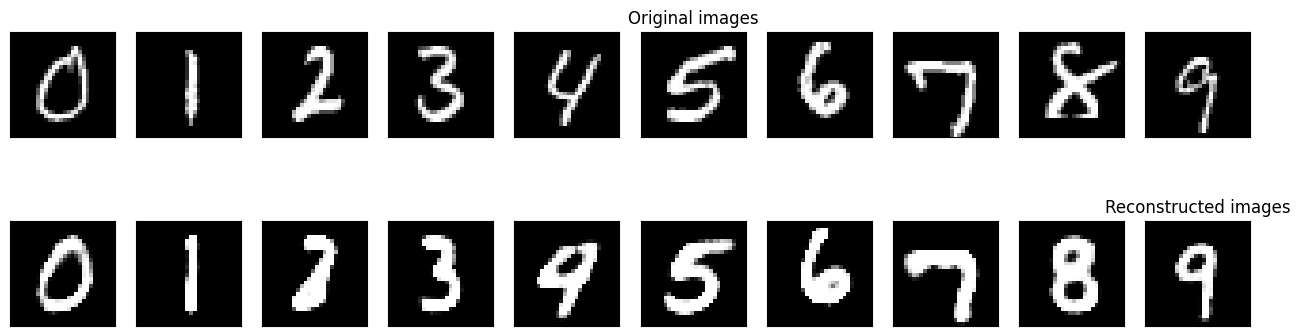

Epoch 23/50 VAE train loss: 442.0759
Epoch 23/50 VAE validation loss: 886.9476


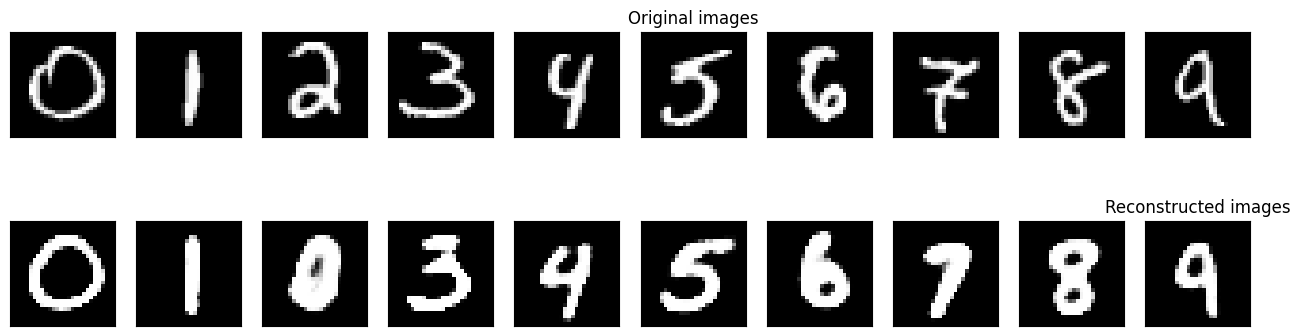

Epoch 24/50 VAE train loss: 441.8722
Epoch 24/50 VAE validation loss: 885.4829


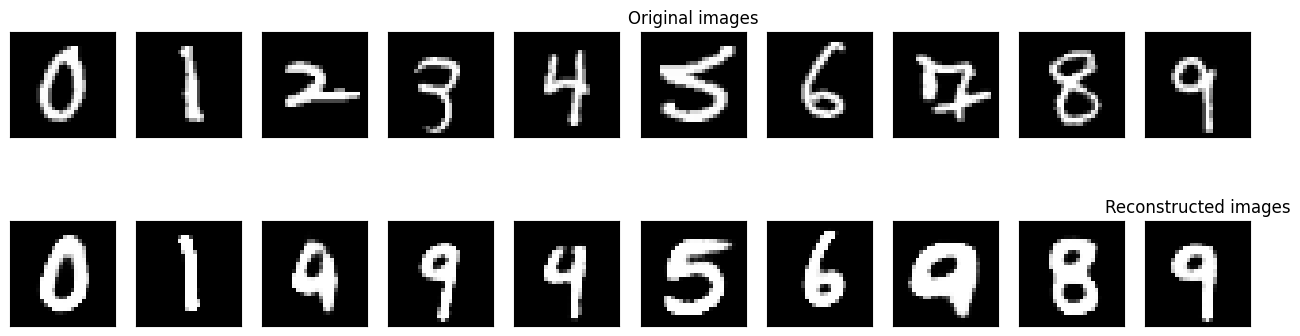

Epoch 25/50 VAE train loss: 441.3895
Epoch 25/50 VAE validation loss: 885.6052


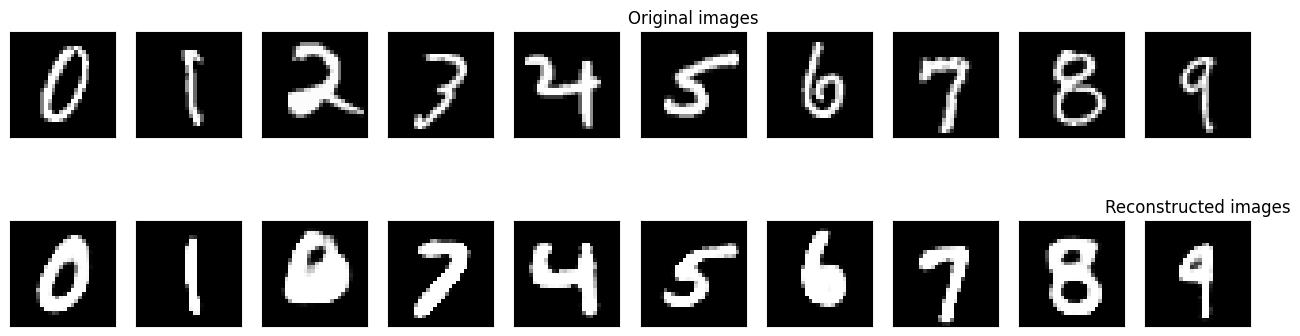

Epoch 26/50 VAE train loss: 441.1355
Epoch 26/50 VAE validation loss: 885.1807


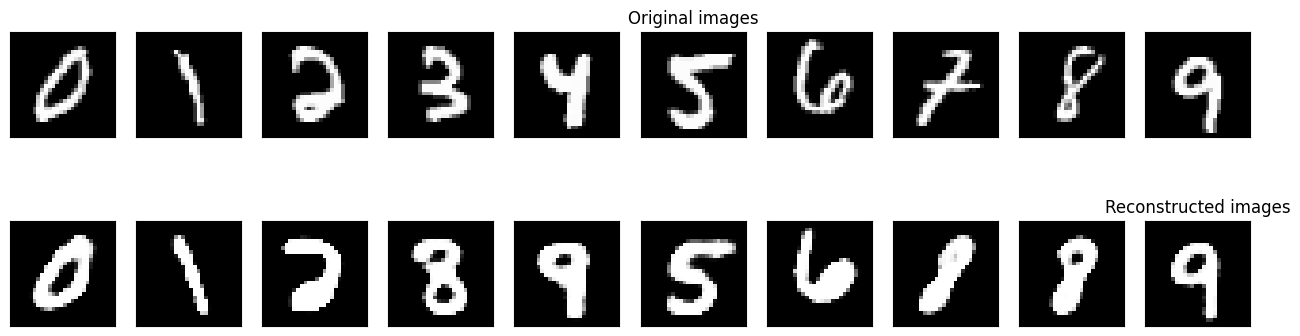

Epoch 27/50 VAE train loss: 440.9011
Epoch 27/50 VAE validation loss: 884.3020


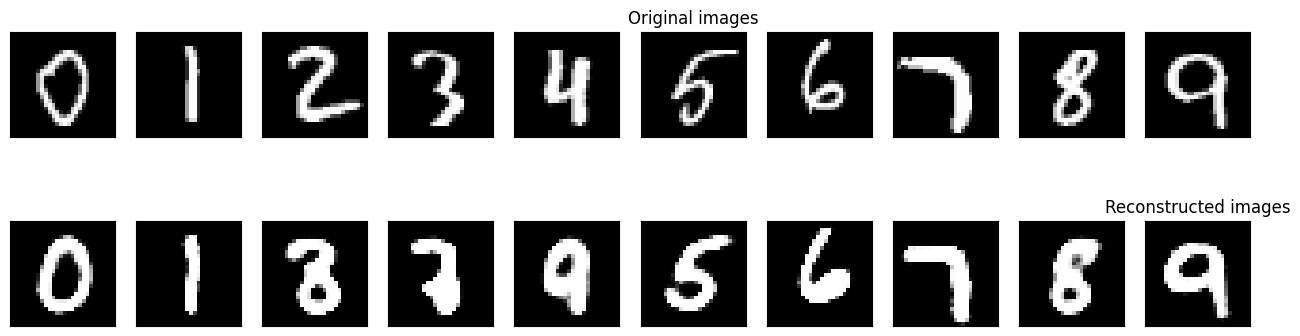

Epoch 28/50 VAE train loss: 440.7579
Epoch 28/50 VAE validation loss: 885.7110


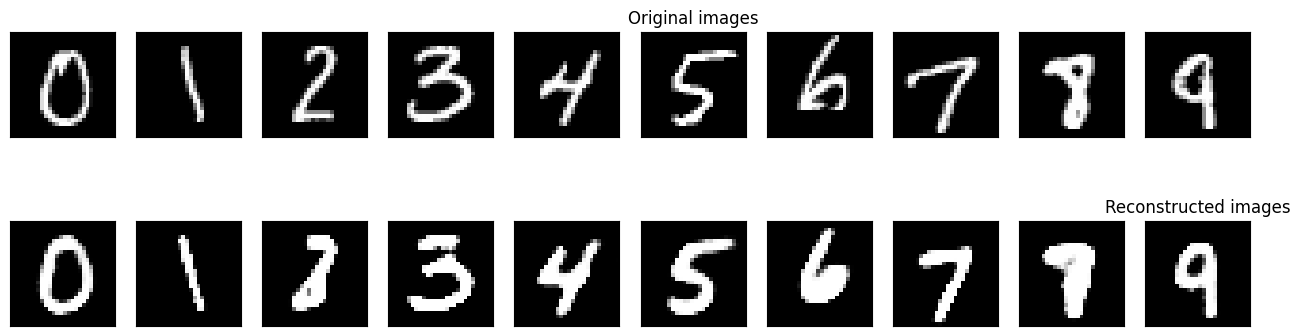

Epoch 29/50 VAE train loss: 440.2787
Epoch 29/50 VAE validation loss: 884.7331


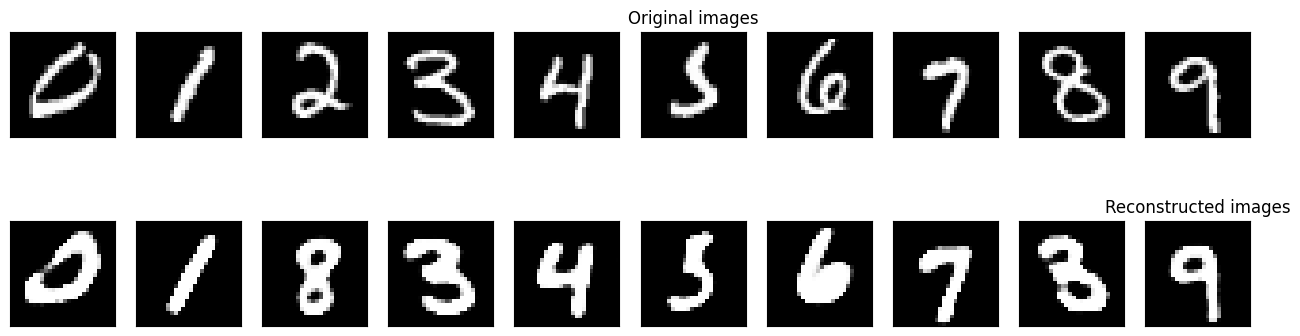

Epoch 30/50 VAE train loss: 440.3183
Epoch 30/50 VAE validation loss: 885.3557
Early stopping at epoch 30/50


In [ ]:
d = 4

epochs = 50
vae_model = VariationalAutoencoder(latent_dims=d).to(device)
optimal_VAE_model, _VAE_train_losses, VAE_val_losses, last_epoch = train_VAE(imbalanced_train_dataloader, imbalanced_val_dataloader, model = vae_model, epochs=epochs)

# Data Generator

In [ ]:
def generate_data(data_set, cls):
    targets = data_set.targets
    sizee = len(np.where(targets==cls)[0])
    idx = np.where(targets==cls)[0][np.random.randint(sizee, size=1)[0]]
    img = data_set[idx][0].unsqueeze(0).to(device)
    vae.encoder.eval()
    vae.decoder.eval()
    with torch.no_grad():
        rec_img  = vae.decoder(vae.encoder(img))
    rec_img = rec_img*255
    orignal_image = img.squeeze().cpu()
    rec_img = rec_img.to(torch.int).squeeze(0).cpu()
    return rec_img, orignal_image

In [ ]:
# print('Distribution of classes in Imbalanced dataset:')
# print(Counter(imbalanced_train_loader.dataset.targets.numpy()))
# fig, ax = plt.subplots()
# _, counts = np.unique(imbalanced_train_loader.dataset.targets, return_counts=True)
# ax.bar(range(10), counts)
# ax.set_xticks(range(10))
# plt.show()

# Finding Dominant Class in Imbalanced Dataset

In [ ]:
def find_dominant_class(imbalanced_train_dataset):
    class_distibution = Counter(imbalanced_train_dataset.targets.numpy())
    dominant_class_num = 0
    for i in class_distibution:
        if class_distibution[i] > dominant_class_num:
            dominant_class_num = class_distibution[i]

    return dominant_class_num, class_distibution

# Start Appending Data To Imbalanced Dataset

In [ ]:
dominant_class_num, class_distibution = find_dominant_class(imbalanced_train_dataset)
aug_imbalanced_train_dataset = copy.deepcopy(imbalanced_train_dataset)
for i in class_distibution:
    print("======"*10)
    print("\nCreating Data for Class: ", i)
    print("======"*10)
    generate_samples = int(dominant_class_num - class_distibution[i])
    for j in range(generate_samples-1):
        if j%500 == 0:
            print(j," Samples created...")
        synthetic_image, orignal_image = generate_data(imbalanced_train_dataset, i)
        pred = synthetic_image
        gt = orignal_image
        aug_imbalanced_train_dataset.targets = torch.tensor(np.append(aug_imbalanced_train_dataset.targets, [i],axis=0))
        aug_imbalanced_train_dataset.data =  torch.tensor(np.append(aug_imbalanced_train_dataset.data, synthetic_image.to(torch.uint8),axis=0))


imbalanced_train_dataset_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1302,), (0.3069,))
])
aug_imbalanced_train_dataset.transform = imbalanced_train_dataset_transform
aug_imbalanced_train_loader = torch.utils.data.DataLoader(aug_imbalanced_train_dataset, batch_size=128, shuffle=True)


Creating Data for Class:  0
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...
2500  Samples created...

Creating Data for Class:  4
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...
2500  Samples created...
3000  Samples created...
3500  Samples created...

Creating Data for Class:  1
0  Samples created...

Creating Data for Class:  9
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...

Creating Data for Class:  3
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...
2500  Samples created...
3000  Samples created...
3500  Samples created...
4000  Samples created...
4500  Samples created...

Creating Data for Class:  7

Creating Data for Class:  2
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples create

# Bar Plot Synthetic Balanced Dataset

Distribution of classes in augmented Imbalanced dataset:
Counter({7: 5609, 0: 5608, 4: 5608, 1: 5608, 9: 5608, 3: 5608, 2: 5608, 6: 5608, 5: 5608, 8: 5608})


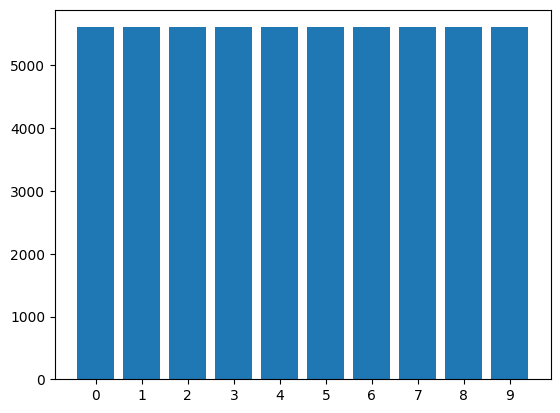

In [ ]:
train_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))])

test_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))])

imbalanced_train_dataset.transform = train_transform
test_ds.transform = test_transform

train_dataloader = torch.utils.data.DataLoader(imbalanced_train_dataset, batch_size=128, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=500, shuffle=True)

print('Distribution of classes in augmented Imbalanced dataset:')
print(Counter(aug_imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(aug_imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

In [ ]:
m = len(aug_imbalanced_train_dataset)

aug_imbalanced_train_data, aug_imbalanced_val_data = random_split(aug_imbalanced_train_dataset, [int(m-m*0.2), m - int(m-m*0.2)])

aug_imbalanced_train_dataloader = torch.utils.data.DataLoader(aug_imbalanced_train_dataset, batch_size=128, shuffle=True)
aug_imbalanced_val_dataloader = torch.utils.data.DataLoader(aug_imbalanced_val_data, batch_size=128, shuffle=True)

# Train the above model like done earlier and print test data performance


In [ ]:
epochs = 10
aug_imb_optimal_model, aug_imb_train_losses, aug_imb_val_losses, aug_imb_val_accuracies, aug_imb_last_epoch = train(aug_imbalanced_train_dataloader, aug_imbalanced_val_dataloader, ConvNet().to(device), epochs=epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/10 train loss: 1.2639
Epoch 1/10 validation loss: 1.1290
Epoch 1/10 validation accuracy: 57.5377
Epoch 2/10 train loss: 1.0871
Epoch 2/10 validation loss: 1.0666
Epoch 2/10 validation accuracy: 59.6060
Epoch 3/10 train loss: 1.0525
Epoch 3/10 validation loss: 1.0518
Epoch 3/10 validation accuracy: 59.7129
Epoch 4/10 train loss: 1.0373
Epoch 4/10 validation loss: 1.0295
Epoch 4/10 validation accuracy: 60.3548
Epoch 5/10 train loss: 1.0262
Epoch 5/10 validation loss: 1.0264
Epoch 5/10 validation accuracy: 60.4529
Epoch 6/10 train loss: 1.0197
Epoch 6/10 validation loss: 1.0145
Epoch 6/10 validation accuracy: 60.9610
Epoch 7/10 train loss: 1.0150
Epoch 7/10 validation loss: 1.0129
Epoch 7/10 validation accuracy: 60.9878
Epoch 8/10 train loss: 1.0100
Epoch 8/10 validation loss: 1.0111
Epoch 8/10 validation accuracy: 60.5420
Epoch 9/10 train loss: 1.0071
Epoch 9/10 validation loss: 1.0085
Epoch 9/10 validation accuracy: 61.1661
Epoch 10/10 train loss: 1.0047
Epoch 10/10 validation l

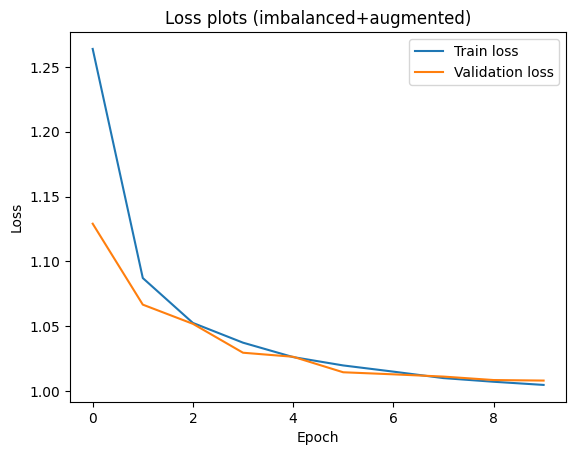

In [ ]:
plt.plot(np.array(range(imb_last_epoch+1)), aug_imb_train_losses, label = "Train loss")
plt.plot(np.array(range(imb_last_epoch+1)), aug_imb_val_losses, label = "Validation loss")
plt.title('Loss plots (imbalanced+augmented)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

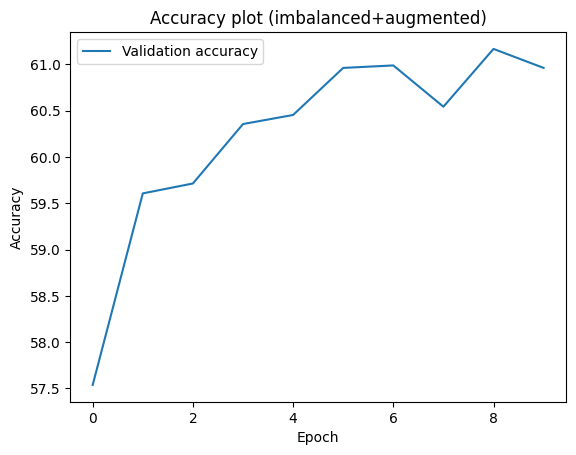

In [ ]:
plt.plot(np.array(range(aug_imb_last_epoch+1)), aug_imb_val_accuracies, label = "Validation accuracy")
plt.title('Accuracy plot (imbalanced+augmented)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
aug_imb_optimal_model_test_acc, cf = test(aug_imb_optimal_model)
percentages2 = get_class_percentages(cf)
print("test accuracy : ", str(aug_imb_optimal_model_test_acc))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)



Test dataset: Overall Loss: 0.0757, Overall Accuracy: 9773/10000 (98%)

test accuracy :  97.73


# Comparison with baseline


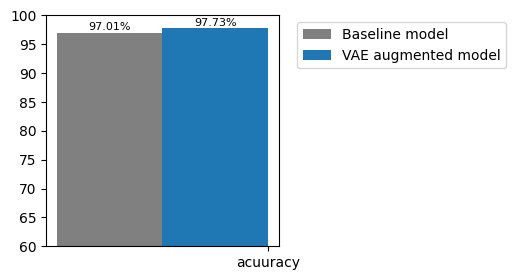

In [ ]:
imb_optimal_model_test_acc
aug_imb_optimal_model_test_acc


fig= plt.subplots(figsize=(3, 3))

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]

p1 = plt.bar(br1, np.array(imb_optimal_model_test_acc).astype(float), width = 0.1, label ='Baseline model', color='gray')
p2 = plt.bar(br2, np.array(aug_imb_optimal_model_test_acc).astype(float), width = 0.1, label ='VAE augmented model')

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=8)

plt.xticks([r + 0.15 for r in range(1)],
        ['acuuracy'])
plt.ylim(60, 100)
# plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

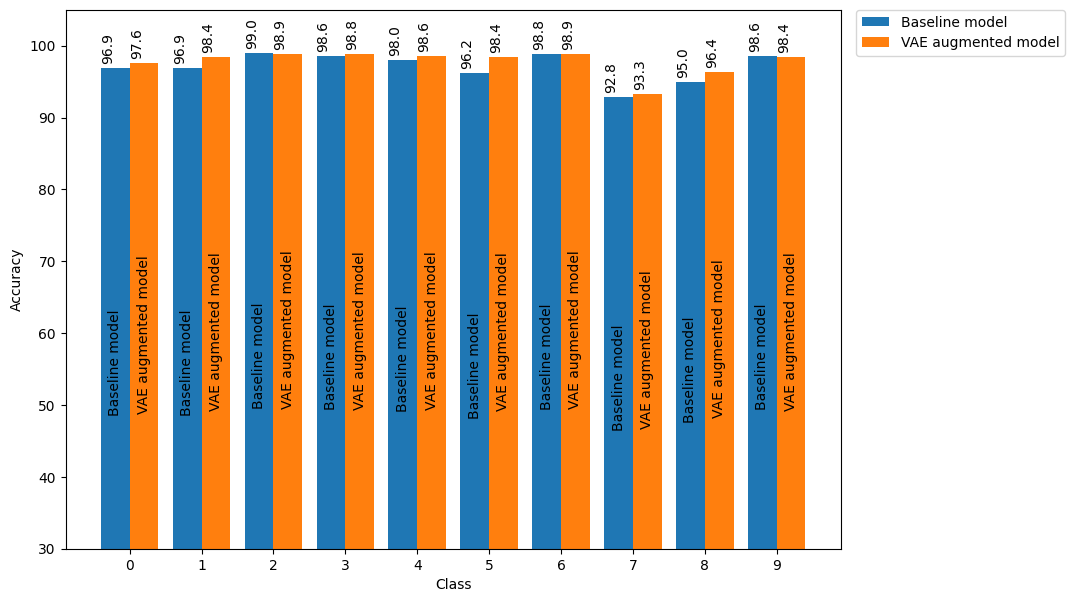

In [ ]:
fig= plt.subplots(figsize=(10, 7))
br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
bar1 = plt.bar(br1, np.char.strip(np.diagonal(percentages1), '%').astype(float), width = 0.4, label ='Baseline model')
bar2 = plt.bar(br2, np.char.strip(np.diagonal(percentages2), '%').astype(float), width = 0.4, label ='VAE augmented model')
plt.xticks([r + 0.2 for r in range(10)],
        ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.ylim(30, 105)
for i, rect in enumerate(bar1 + bar2):
    height = rect.get_height()/2
    if i>9:
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, "VAE augmented model", ha='center', va='bottom', rotation='vertical')
    else:
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, "Baseline model" , ha='center', va='bottom', rotation='vertical')

for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 1, "%.1f"%(yval), rotation='vertical')

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 1, "%.1f"%(yval), rotation='vertical')


plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.xlabel('Class')
plt.ylabel('Accuracy')

plt.show()